# pyMSO4 example 1
Using p2p ethernet and a CW305 FPGA board, we will acquire 1000 encryption
traces of the same plaintext.

## Scope configuration
- Connect the SMA cable to channel 1 (with an SMA-BNC adaptor) and to the X4
signal on the CW305 (top right corner)
- Connect a probe to channel 2
- Connect the probe to the trigger out signal (TP1) on the CW305 (bottom right
corner)
- Connect the scope to the computer using an Ethernet cable (see manual)

![Setup](img/ex1_setup.jpg)

In [1]:
import pyMSO4

import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pyvisa as visa
import chipwhisperer as cw

TIMEOUT = 2000
TIMEOUT_SHORT = 200 # Used when running the acquisition loop and don't want to waste time on a missed trigger
SCOPE_ADDR = "128.181.240.130" # Using p2p ethernet connection, change with your IP if using a switch

def prep(scope: pyMSO4.MSO4):
	scope.timeout = TIMEOUT
	scope.reset() # NOTE without this, it will not be possible to recover the scope when the TCP connection hangs
	scope.display = False # NOTE: if True, you need to increase TIMEOUT_SHORT

	# Enable channels 1 and 2
	scope.ch_a_enable([True, True, False, False])
	scope.ch_a[1].scale = 0.01
	scope.ch_a[2].scale = 1

	# Set up horizontal settings (can also go in auto mode here and set the sample_rate only)
	scope.acq.horiz_mode = 'manual'
	scope.acq.horiz_sample_rate = 6.25e9 # 6.25 GS/s
	scope.acq.horiz_record_length = 12500 # 12,5 kS
	scope.acq.horiz_scale = 200e-9 # 200 ns
	scope.acq.horiz_pos = 10

	# Set up trigger
	scope.trigger.mode = 'normal'
	scope.trigger.source = 'CH2'
	scope.trigger.level = 1.4
	scope.trigger.edge_slope = 'rise'

	# Use default data acquisition settings

	# Set up the scope to output the entire waveform
	for _ in range(3): # Might take some persistence to get the scope to update Nr_Pt
		scope.acq.wfm_src = ['CH1']
		scope.acq.wfm_start = 1
		scope.acq.wfm_stop = 12500
		# Force a trigger to get the scope to update Nr_Pt and avoid cutting off future waveforms
		# While writing DATA above should be enough, it actually does not update the internal settings until a trace
		# is acquired. Too bad, these settings are NOT updated in CURVESTREAM mode, so in our case they'd never be changed.
		scope.trigger.force()
		if scope.acq.wfm_len == 12500:
			break
	assert scope.acq.wfm_len == 12500
	scope.clear_cmd()

	scope.acq.fast_acq = True
	scope.acq.mode = 'hires'


In [2]:
# Connect to the scope
mso44 = pyMSO4.MSO4(trig_type=pyMSO4.MSO4EdgeTrigger, timeout=TIMEOUT, debug=False)
mso44.con(ip=SCOPE_ADDR)

# Configure the target
# On the CW305, setting force=False only programs the FPGA if it is currently unprogrammed, whereas force=True programs the FPGA regardless.
# This option isn't available on the CW312T_A35 or CW312T_ICE40.
fpga_id = '100t'
target = cw.target(None, cw.targets.CW305, force=True, fpga_id=fpga_id)

# run at 10 MHz:
target.pll.pll_outfreq_set(10E6, 1)

# Finally acquire data from the scope

In [3]:
TRACES = 1000

# Configure the scope
prep(mso44)
print("Scope configured")

# Enable curvestream
mso44.acq.curvestream = True
mso44.clear_buffers() # Good measure

# Start acquisition
traces = []
mso44.timeout = TIMEOUT_SHORT
start = time.time()

for i in tqdm(range(TRACES)):
	# Here we send plaintext to the target for it to be encrypted, and wait for the output
	# to be ready. This guarantees we will have a trace ready to be read
	target.simpleserial_write('p', b'\x00' * 16)
	response = target.simpleserial_read('r', target.output_len, ack=True)
	try:
		# NOTE calling get_datatype and reading is_big_endian will result in commands being
		# sent to the scope, which in turn will disable curvestream mode. This is fine
		# because they are cached after the first call, and the first acquisition always
		# times out anyway (?)
		trace = mso44.sc.read_binary_values(datatype=mso44.acq.get_datatype(), is_big_endian=mso44.acq.is_big_endian)
	except visa.errors.VisaIOError as e:
		if e.error_code == visa.constants.VI_ERROR_TMO:
			print("Timeout on trace acquisition, retrying")
			mso44.clear_buffers()
			mso44.acq.curvestream = True
			continue
		else:
			raise
	if traces and trace == traces[-1]:
		# This should never happen because the scope send buffer is always cleared on a read, but...
		print("Duplicate trace detected")
	traces.append(trace)
end = time.time()
mso44.timeout = TIMEOUT # Reset timeout
mso44.acq.curvestream = False
print(f"Captured {len(traces)} traces in {end - start} seconds")

Scope configured


  0%|          | 0/1000 [00:00<?, ?it/s]

Timeout on trace acquisition, retrying
Timeout on trace acquisition, retrying
Captured 998 traces in 139.72346377372742 seconds


## Cleanup and plot

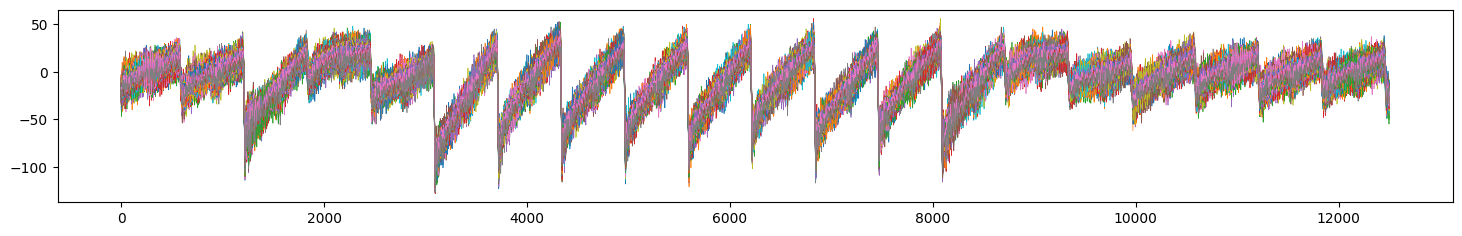

In [4]:
# Cleanup
mso44.dis()
target.dis()

plt.figure(1, figsize=(18, 2.5)) # Make it look similar to the scope
for trace in traces:
	plt.plot(trace, linewidth=.5, markersize=5)